In [193]:
# import valid libaries
import matplotlib.pyplot as plt
import matplotlib.pyplot as py
import numpy as np
import gdsfactory as gf
import gdsfactory.simulation.gmeep as gm
import gdsfactory.simulation as sim
import gdsfactory.simulation.modes as gm
import meep as mp
import sys
from datetime import datetime
import scipy
from scipy.optimize import curve_fit
import matplotlib.ticker as ticker
import pandas as pd
import math
import os
import csv
import time
import findiff as fd


In [194]:
# frequency lambda conversions
def lambda_omega_conversion(parameter):
    return 2 * np.pi * 299792458 / parameter

/tmp/ipykernel_26308/906897896.py:3: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  dictionary = pd.read_csv(directory+"/header.csv", header=None, index_col=0, squeeze=True).to_dict()


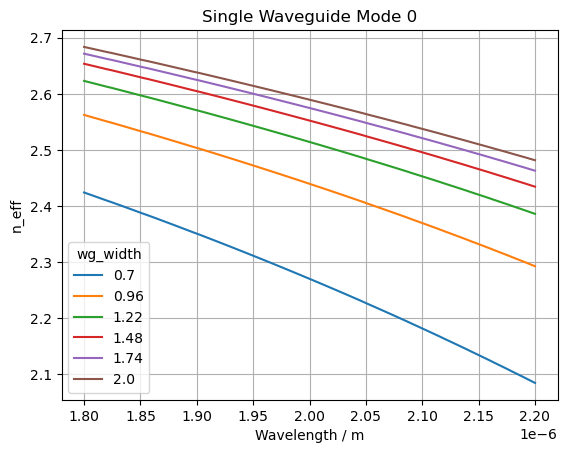

In [195]:
# get parameters from csv file
directory = 'waveguide_width_sweeps_BIG_2_resolution_70_sybase4_wg_initial_width0.7_wg_final_width2_w_k_sweep_steps100'
dictionary = pd.read_csv(directory+"/header.csv", header=None, index_col=0, squeeze=True).to_dict()

# import parameters
mode = int(dictionary['mode'])
side_angles = dictionary['side_angles']
wg_thickness = dictionary['wg_thickness']
waveguide_temperature = dictionary['waveguide_temperature']

# simulation parameters
resolution = dictionary['resolution']
sy_base = dictionary['sy_base']

# wavelength w k sweep parameters
start_wavelength = dictionary['start_wavelength']
end_wavelength = dictionary['end_wavelength']
w_k_sweep_steps = int(dictionary['w_k_sweep_steps'])

# sweeping waveguide width, in um
wg_initial_width = dictionary['wg_initial_width']
wg_final_width = dictionary['wg_final_width']
wg_width_sweep_steps = int(dictionary['wg_width_sweep_steps'])

# import 
widths = np.linspace(wg_initial_width,wg_final_width,wg_width_sweep_steps)
wavelengths = np.linspace(start_wavelength,end_wavelength,w_k_sweep_steps)

n_eff = np.zeros([wg_width_sweep_steps,mode,w_k_sweep_steps])
a_eff = np.zeros([wg_width_sweep_steps,mode,w_k_sweep_steps])

py.figure()

for index_width, wg_width in enumerate(widths):
    # open file
    filename = directory + '/'+str(wg_width)+'.csv'
    with open(filename, 'r') as file:
        csvreader = csv.reader(file)
        next(csvreader, None)
        for index_row, row in enumerate(csvreader):
            read_mode = int(row[1])
            read_neff = row[2]
            read_aeff = row[3]
            wavelength_index = int(np.floor(index_row/mode))
            n_eff[index_width][read_mode][wavelength_index] = read_neff
            a_eff[index_width][read_mode][wavelength_index] = read_aeff

    current_mode=0
    py.plot(wavelengths,n_eff[index_width,current_mode,:])


py.xlabel('Wavelength / m')
py.title('Single Waveguide Mode '+str(current_mode))
py.ylabel('n_eff')
py.grid('on')
py.legend(widths,title='wg_width')


Text(0.5, 0, 'Wavelength / m')

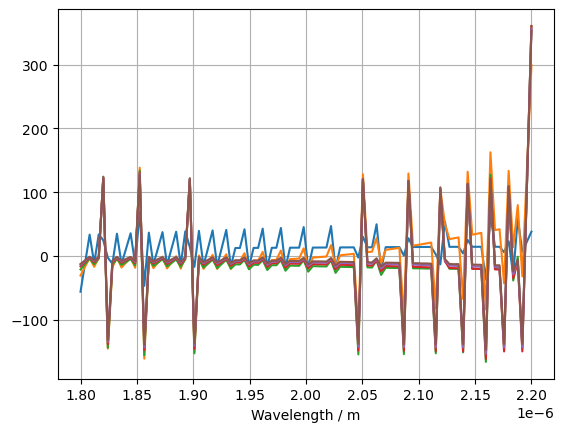

In [196]:
current_mode=1
ps = 1E-12

for index_width, wg_width in enumerate(widths):
    # calculate b_0
    beta_0 = 2 * math.pi * n_eff[index_width,current_mode,:] / wavelengths
    omegas = lambda_omega_conversion(wavelengths)

    # setup differential calculators
    d_dx1 = fd.FinDiff(0,omegas,1,accuracy=2)
    d_dx2 = fd.FinDiff(0,omegas,2,accuracy=2)
    d_dx3 = fd.FinDiff(0,omegas,3,accuracy=2)

    # calculate b1
    beta_1 = d_dx1(beta_0)/ps
    beta_2 = d_dx2(beta_0)/ps**2
    beta_3 = d_dx3(beta_0)/ps**3
    py.plot(wavelengths,beta_2)
    
py.grid('on')
py.xlabel('Wavelength / m')
# this does not work
# too senstive to noise



In [197]:
def poly_10(x_value,co1,co2,co3,co4,co5,co6,co7,co8,co9,co10):
    return co1 + co2 * x_value + co3 * x_value**2 + co4 * x_value**3 + co5 * x_value **4 + co6 * x_value**5 + co7 * x_value**6 + co8 * x_value**7 + co9 * x_value**8  + co10 * x_value**9
def poly_9(x_value,co1,co2,co3,co4,co5,co6,co7,co8,co9):
    return co1 + co2 * x_value + co3 * x_value**2 + co4 * x_value**3 + co5 * x_value **4 + co6 * x_value**5 + co7 * x_value**6 + co8 * x_value**7 + co9 * x_value**8 
def poly_8(x_value,co1,co2,co3,co4,co5,co6,co7,co8):
    return co1 + co2 * x_value + co3 * x_value**2 + co4 * x_value**3 + co5 * x_value **4 + co6 * x_value**5 + co7 * x_value**6 + co8 * x_value**7 
def poly_7(x_value,co1,co2,co3,co4,co5,co6,co7):
    return co1 + co2 * x_value + co3 * x_value**2 + co4 * x_value**3 + co5 * x_value **4 + co6 * x_value**5 + co7 * x_value**6 
def poly_6(x_value,co1,co2,co3,co4,co5,co6):
    return co1 + co2 * x_value + co3 * x_value**2 + co4 * x_value**3 + co5 * x_value **4 + co6 * x_value**5
def poly_5(x_value,co1,co2,co3,co4,co5):
    return co1 + co2 * x_value + co3 * x_value**2 + co4 * x_value**3 + co5 * x_value **4
def poly_4(x_value,co1,co2,co3,co4):
    return co1 + co2 * x_value + co3 * x_value**2 + co4 * x_value**3
def poly_3(x_value,co1,co2,co3):
    return co1 + co2 * x_value + co3 * x_value**2

In [198]:
def get_beta_diffs(beta_poly_coeff,poly_order,beta_order_max=2):
    # loop over all of the desired beta values
    differential_coeffs = np.arange(1,poly_order+1,1)
    for i in range(beta_order_max):
        # shift over coefficents
        for j in range(poly_order-1):
            beta_poly_coeff[i+1][j] = beta_poly_coeff[i][j+1]
        # times by prefactor
        beta_poly_coeff[i+1][:] = beta_poly_coeff[i+1][:] * differential_coeffs 

    return beta_poly_coeff

In [199]:
def get_beta_coeff_initial(poly_order,sample_eff_indexes,sample_wavelengths,sample_frequencys,beta_order_max=2):
    # keep track of all beta values
    beta_poly_coeff = np.zeros([beta_order_max+1,poly_order])

    # calculate beta_0
    # convert indexes to beta values
    sample_beta_0 = 2 * np.pi * sample_eff_indexes / sample_wavelengths
    # function fit for freq against beta_0
    beta_0_coeff,beta_0_cov = curve_fit(poly_4,sample_frequencys, sample_beta_0)
    beta_poly_coeff[0][:] = beta_0_coeff
    return beta_poly_coeff

In [200]:
def fit_beta(current_mode,width_index,poly_min=4,poly_max=10):
    # unit conversions
    ps = 1E-12
    ps2 = ps * ps
    u = 1E-6

    # pick a width
    n_eff_wgwidth = n_eff[width_index,current_mode,:]

    # get n_eff plots against frequency
    lambda_datapoints = 500
    linspace_wavelength = np.linspace(start_wavelength,end_wavelength,lambda_datapoints)
    linspace_frequency = lambda_omega_conversion(linspace_wavelength)

    # get subset of data
    min_datapoints=20
    max_datapoints=w_k_sweep_steps
    step_datapoints = max_datapoints-min_datapoints

    beta_order_max = 5

    datapoints_array = np.linspace(min_datapoints,max_datapoints,step_datapoints)
    datapoints_array = datapoints_array.astype(int)

    GVD_array = np.zeros([poly_max-poly_min+1,step_datapoints])
    beta_3_array = np.zeros([poly_max-poly_min+1,step_datapoints])
    beta_4_array = np.zeros([poly_max-poly_min+1,step_datapoints])
    ng_array = np.zeros([poly_max-poly_min+1,step_datapoints])
    n_eff_array = np.zeros([poly_max-poly_min+1,step_datapoints])

    pols = np.arange(poly_min,poly_max+1,step=1)
    datas = np.zeros(step_datapoints)
    beta_all_poly_coeffs = np.zeros([poly_max-poly_min+1,beta_order_max+1,poly_max])
    n_eff_coeff=0
    test_wavelength = 2.051 * u

    for i in range(poly_min,poly_max+1,1):
        # choose polynomial function
        string = 'poly_'+str(i)
        poly_i = eval(string)
        for j in range(step_datapoints):
            datapoints_sample = datapoints_array[j]
            datas[j] = datapoints_sample
            sample_list = np.linspace(0,w_k_sweep_steps-1,datapoints_sample)
            sample_list = sample_list.astype(int)
            subsample_wavelengths = wavelengths[sample_list]
            subsample_frequencys = omegas[sample_list]
            subsample_n_eff = n_eff_wgwidth[sample_list]
            
            if (j==0):
                if (i==poly_min):
                    n_eff_coeff,n_eff_cov = curve_fit(poly_i,subsample_frequencys,subsample_n_eff)
            else:
                n_eff_coeff,n_eff_cov = curve_fit(poly_i,subsample_frequencys,subsample_n_eff,p0=[n_eff_coeff])
            
            n_eff_sample = poly_i(lambda_omega_conversion(2.071*u),*n_eff_coeff)
            beta_poly_coeff = np.zeros([beta_order_max+1,i])

            # calculate beta_0
            # convert indexes to beta values
            sample_beta_0 = 2 * np.pi * subsample_n_eff / subsample_wavelengths
            # function fit for freq against beta_0
            if (j==0):
                if (i==poly_min):
                    beta_0_coeff,beta_0_cov = curve_fit(poly_i,subsample_frequencys, sample_beta_0) 
            beta_0_coeff,beta_0_cov = curve_fit(poly_i,subsample_frequencys,sample_beta_0,p0=[beta_0_coeff],maxfev=20000,gtol=1e-13,xtol=1e-13,ftol=1e-15)
            beta_poly_coeff[0][:] = beta_0_coeff
            beta_poly_coeff = get_beta_diffs(beta_poly_coeff,i,beta_order_max)
            GVD = poly_i(lambda_omega_conversion(test_wavelength),*beta_poly_coeff[2][:])/ps2
            beta_3 = poly_i(lambda_omega_conversion(test_wavelength),*beta_poly_coeff[3][:])/(ps*ps*ps)
            beta_4 = poly_i(lambda_omega_conversion(test_wavelength),*beta_poly_coeff[4][:])/(ps*ps*ps*ps)
            
            ng = 299792458 * poly_i(lambda_omega_conversion(test_wavelength),*beta_poly_coeff[1][:])
            
            GVD_array[i-poly_min][j] = GVD
            ng_array[i-poly_min][j] = ng
            n_eff_array[i-poly_min][j] = n_eff_sample
            beta_3_array[i-poly_min][j] = beta_3
            beta_4_array[i-poly_min][j] = beta_4
        for k in range(beta_order_max+1):
            current_coefficents = beta_poly_coeff[k][:]
            for m in range(np.size(current_coefficents)):
                beta_all_poly_coeffs[i-poly_min][k][m] = beta_poly_coeff[k][m]
        n_eff_coeff = np.append(n_eff_coeff,[0])
        beta_0_coeff = np.append(beta_0_coeff,[0])
    return beta_all_poly_coeffs

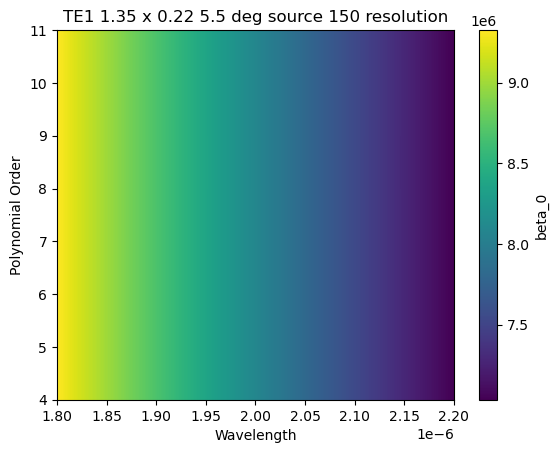

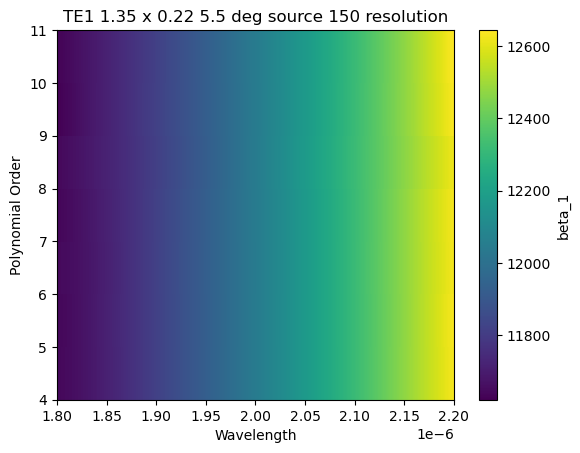

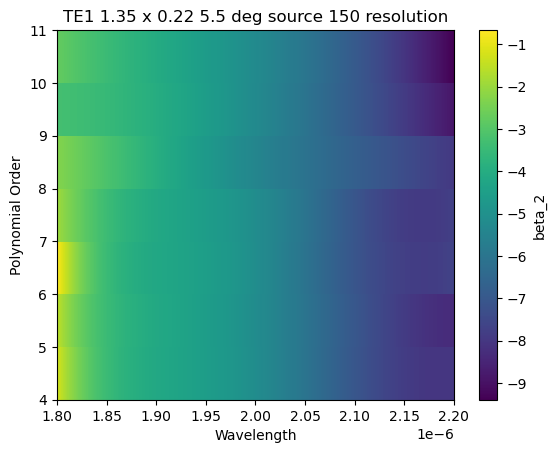

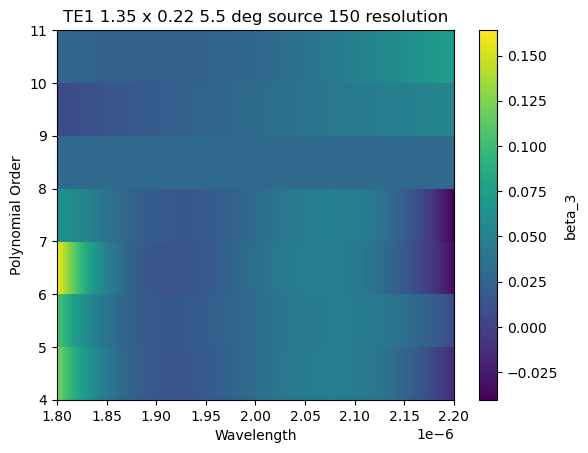

In [208]:
# time to do some sweeping
test_wavelength_start =  start_wavelength
test_wavelength_end =  end_wavelength
test_datapoints = 1000
test_linspace_wavelength = np.linspace(test_wavelength_start,test_wavelength_end,test_datapoints)
test_linspace_frequency = lambda_omega_conversion(test_linspace_wavelength)

poly_min_2 = 4
poly_min = 4
poly_max = 10
beta_order_max = 3
offset = poly_min_2 - poly_min
# lets start with beta_0
plot = True
m = 0
# waveguide width
width_index = 4
beta_all_poly_coeffs = fit_beta(current_mode,width_index)

for j in range(beta_order_max+1):
    wavelength_sample_2d = np.zeros([poly_max-poly_min_2+1,test_datapoints])
    for i in range(poly_max-poly_min_2+1):
        wavelength_sample_2d[i][:] = poly_10(test_linspace_frequency,*beta_all_poly_coeffs[i+offset-poly_min][j][:])/(ps**j)
    if (plot):
        py.figure()
        py.imshow(wavelength_sample_2d, aspect='auto', extent=[test_wavelength_start,test_wavelength_end,poly_min_2,poly_max+1],origin='lower', interpolation='none')
        py.locator_params(axis='y',nbins=(poly_max-poly_min)*2)
        py.xlabel('Wavelength')
        py.colorbar(label=('beta_'+str(j)))
        py.ylabel('Polynomial Order')
        py.title('TE1 1.35 x 0.22 5.5 deg source 150 resolution')
        m = m+1


In [223]:
def plot_sweeps(beta_order,poly_num,current_mode):
    py.figure()
    for width_index, wg_width in enumerate(widths):
        # get beta coefficents
        beta_all_poly_coeffs = fit_beta(current_mode,width_index)
        # get beta_n
        beta_n = poly_10(omegas,*beta_all_poly_coeffs[poly_num-poly_min][beta_order][:])/(ps**beta_order)
        # convert to neff (comment out if needed)
        #beta_n = beta_n * wavelengths / (2 * math.pi) ######### CAN COMMENT OUT
        plt.subplot(2, 1, 2)
        py.xlabel('Wavelength / um')
        py.grid('on')
        py.ylabel('beta'+str(beta_order))
        py.title('Single Waveguide, Mode '+str(current_mode))
        py.plot(lambda_omega_conversion(omegas),beta_n)
        #py.plot(lambda_omega_conversion(omegas),n_eff[width_index,current_mode,:])

    py.legend(widths,title='Wg_Width')

/home/sgears/mambaforge/envs/mp/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


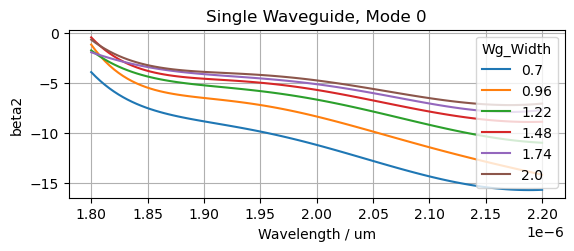

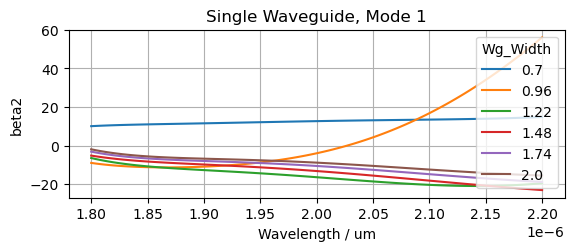

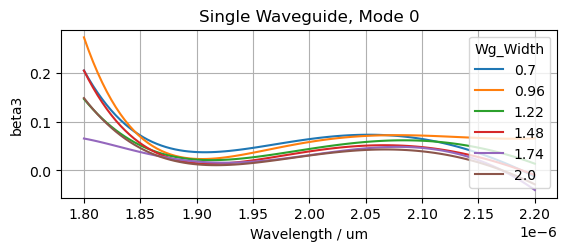

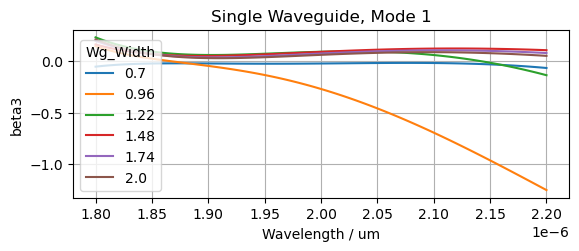

In [224]:
# plot the desired beta values
beta_order = 3
poly_num = 10


plot_sweeps(beta_order=2,poly_num=10,current_mode=0)
plot_sweeps(beta_order=2,poly_num=10,current_mode=1)
plot_sweeps(beta_order=3,poly_num=10,current_mode=0)
plot_sweeps(beta_order=3,poly_num=10,current_mode=1)


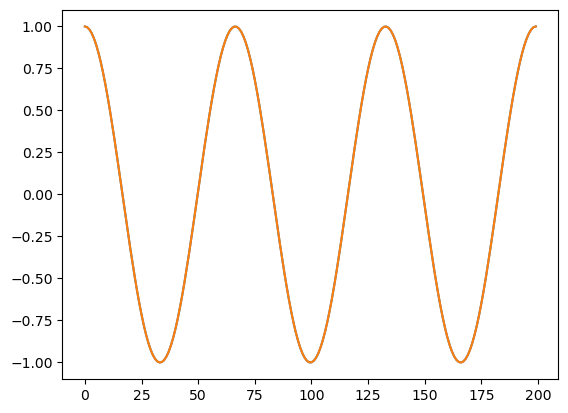

In [85]:


x = np.linspace(0,6*math.pi,200)
spacing = (6*math.pi/200)

y = np.cos(x)

d_dx = fd.FinDiff(0,x,4,acc=6)
df_dx = d_dx(y)

py.plot(y)
py.plot(df_dx)